In [1]:
import os
os.chdir("../../")

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import catboost as cb
from scr.util import *

In [31]:
df_train= pd.read_csv('data/feature_engineered/null_representative/train_null_mean.csv')
df_test = pd.read_csv('data/feature_engineered/null_representative/test_null_mean.csv')

In [32]:
print(len(df_train.columns))
print(len(df_test.columns))

combination_columns = df_train.columns[44:110]
print(combination_columns)
print(len((combination_columns)))

114
113
Index(['TypeofContact_CityTier', 'TypeofContact_Occupation',
       'TypeofContact_Gender', 'TypeofContact_ProductPitched',
       'TypeofContact_PreferredPropertyStar', 'TypeofContact_Passport',
       'TypeofContact_PitchSatisfactionScore', 'TypeofContact_Designation',
       'TypeofContact_Marry', 'TypeofContact_Car', 'TypeofContact_Child',
       'CityTier_Occupation', 'CityTier_Gender', 'CityTier_ProductPitched',
       'CityTier_PreferredPropertyStar', 'CityTier_Passport',
       'CityTier_PitchSatisfactionScore', 'CityTier_Designation',
       'CityTier_Marry', 'CityTier_Car', 'CityTier_Child', 'Occupation_Gender',
       'Occupation_ProductPitched', 'Occupation_PreferredPropertyStar',
       'Occupation_Passport', 'Occupation_PitchSatisfactionScore',
       'Occupation_Designation', 'Occupation_Marry', 'Occupation_Car',
       'Occupation_Child', 'Gender_ProductPitched',
       'Gender_PreferredPropertyStar', 'Gender_Passport',
       'Gender_PitchSatisfactionScore', 'G

### 欠損値を扱う場合

In [124]:
# df_submit_null = pd.read_csv('data/test.csv')

# age_null_id = df_submit_null.loc[df_submit_null['Age'].isna(), 'id'].values
# duration_null_id = df_submit_null.loc[df_submit_null['DurationOfPitch'].isna(), 'id'].values
# trips_null_id = df_submit_null.loc[df_submit_null['NumberOfTrips'].isna(), 'id'].values
# income_null_id = df_submit_null.loc[df_submit_null['MonthlyIncome'].isna(), 'id'].values

# for id in age_null_id:
#     df_submit.loc[df_submit['id'] == id, 'Age'] = np.nan

# for id in duration_null_id:
#     df_submit.loc[df_submit['id'] == id, 'DurationOfPitch'] = np.nan

# for id in trips_null_id:
#     df_submit.loc[df_submit['id'] == id, 'NumberOfTrips'] = np.nan

# for id in income_null_id:
#     df_submit.loc[df_submit['id'] == id, 'MonthlyIncome'] = np.nan

# Catboost

In [33]:
# 特徴量が多いので、落とす特徴量を選択
drop = [
    'EconomicSegment',
    'ContractRate_FM',
    'ContractRate_G1',
    'ContractRate_G2',
    'ContractRate_G3',
    'ContractRate_G4',
    'ContractRate_G5',
    'ContractRate_G6'
]

# catboostでカテゴリ変数を指定するためのリスト
category_columns = ['TypeofContact', 'CityTier', 'Occupation', 'Gender','NumberOfPersonVisiting','NumberOfFollowups', 'ProductPitched', 'PreferredPropertyStar', 'Passport','PitchSatisfactionScore', 'Designation', 'Marry', 'Car', 'Child'] + ['EconomicSegment', 'IsFamily', 'FreaqencySeg','MonetarySeg', 'ContractRate_FM', 'ContractRate_G1','ContractRate_G2', 'ContractRate_G3', 'ContractRate_G4', 'ContractRate_G5', 'ContractRate_G6']

df_train = mapping_columns_if_exist(df_train)
df_test = mapping_columns_if_exist(df_test)

# Label Encoding
# encoder = {col: LabelEncoder() for col in combination_columns}
# for col, encoder in encoder.items():
#     df_train[col] = encoder.fit_transform(df_train[col])
#     df_test[col] = encoder.transform(df_test[col])

def handle_unknown_label(train_series, test_series):
    unique_labels = train_series.unique()
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    train_encoded = train_series.map(label_map)
    test_encoded = test_series.map(lambda x: label_map.get(x, -1))
    return train_encoded, test_encoded

# 各カラムに対してカスタムエンコーディング関数を適用
for col in combination_columns:
    df_train[col], df_test[col] = handle_unknown_label(df_train[col], df_test[col])

X = df_train.drop(columns=drop, axis=1)
y = df_train['ProdTaken']

df_test = df_test.drop(columns=drop, axis=1)

In [34]:
display(X.iloc[:5, 18:])
display(df_test.iloc[:5, 17:])

,Car,Child,AgeGroup,TypeofContactNULL,Motivation,EconomicPower,Child01,TripEasier,SalesPerformance,LivingCost,...,Designation_Marry,Designation_Car,Designation_Child,Marry_Car,Marry_Child,Car_Child,AgeNull,DurationOfPitchNull,NumberOfTripsNull,MonthlyIncomeNull
0,0,0,5,0,14,32.356270,0,48,2.351729,9.572861,...,0,0,0,0,0,0,0,0,0,0
1,1,0,5,0,14,50.350356,0,8,2.375794,8.197046,...,1,1,1,1,1,1,0,0,0,0
2,0,0,3,0,3,37.607704,0,24,1.875412,7.597516,...,2,0,0,2,2,0,1,0,0,0
3,1,0,3,0,3,25.394244,0,8,2.147262,9.301921,...,1,1,1,1,1,1,0,0,0,0
4,1,0,4,0,3,12.462403,0,48,1.731967,11.868956,...,0,2,0,3,0,1,0,0,0,0


,Car,Child,AgeGroup,TypeofContactNULL,Motivation,EconomicPower,Child01,TripEasier,SalesPerformance,LivingCost,...,Designation_Marry,Designation_Car,Designation_Child,Marry_Car,Marry_Child,Car_Child,AgeNull,DurationOfPitchNull,NumberOfTripsNull,MonthlyIncomeNull
0,1,0,4,0,4,34.102241,0,0,1.801646,8.773409,...,7,3,2,4,2,1,0,0,0,0
1,0,0,3,0,14,25.223082,0,8,1.823531,8.819260,...,4,4,1,2,2,0,0,0,0,0
2,0,0,2,0,4,37.405322,0,24,1.430065,8.312294,...,8,0,0,5,1,0,0,0,0,0
3,1,0,2,0,4,32.416696,0,24,1.489417,9.134037,...,1,1,1,1,1,1,0,0,0,0
4,1,0,4,0,4,48.757169,0,48,1.985889,7.937675,...,0,2,0,3,0,1,0,0,0,0


In [36]:
# 学習モデル Regressor

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
cv_list = list(skf.split(X, y))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        
        # 各foldでtarget encodingのやり直し
        tmp = tr_x.groupby(by=['AgeGroup', 'ProductPitched'], as_index=False)['ProdTaken'].mean()
        tmp = tmp.rename(columns={'ProdTaken': 'ContractRate_G4'})
        tr_x = tr_x.merge(tmp, on=['AgeGroup', 'ProductPitched'], how='left')
        va_x = va_x.merge(tmp, on=['AgeGroup', 'ProductPitched'], how='left')
        
        tr_x = tr_x.drop(labels='AgeGroup', axis=1)
        va_x = va_x.drop(labels='AgeGroup', axis=1)
        tr_x = tr_x.drop(labels='ProdTaken', axis=1)
        va_x = va_x.drop(labels='ProdTaken', axis=1)
        
        model = cb.CatBoostRegressor(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict(va_x)
        models.append(model)
    return oof_pred, models

params = {
    'loss_function': 'RMSE',
    'eval_metric': 'AUC',
    'iterations': 7000,
    'learning_rate': 0.005,
    'depth': 5,
    # 'cat_features': category_columns,
    'l2_leaf_reg': 5,  # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X, y, cv_list, params)

0:	test: 0.7986538	best: 0.7986538 (0)	total: 200ms	remaining: 23m 22s
100:	test: 0.8504682	best: 0.8509866 (73)	total: 623ms	remaining: 42.5s
200:	test: 0.8528763	best: 0.8528930 (199)	total: 1.04s	remaining: 35.1s
300:	test: 0.8533612	best: 0.8533946 (299)	total: 1.49s	remaining: 33.2s
400:	test: 0.8551839	best: 0.8552843 (381)	total: 1.93s	remaining: 31.7s
500:	test: 0.8567559	best: 0.8567893 (479)	total: 2.37s	remaining: 30.7s
600:	test: 0.8574247	best: 0.8576254 (594)	total: 2.75s	remaining: 29.3s
700:	test: 0.8573746	best: 0.8577258 (676)	total: 3.1s	remaining: 27.9s
800:	test: 0.8575753	best: 0.8578930 (784)	total: 3.56s	remaining: 27.5s
900:	test: 0.8574916	best: 0.8579599 (851)	total: 3.97s	remaining: 26.9s
1000:	test: 0.8577759	best: 0.8579599 (851)	total: 4.4s	remaining: 26.4s
1100:	test: 0.8574582	best: 0.8579599 (851)	total: 4.84s	remaining: 25.9s
1200:	test: 0.8576421	best: 0.8579599 (851)	total: 5.29s	remaining: 25.5s
1300:	test: 0.8578930	best: 0.8579599 (851)	total: 5.

In [16]:
# モデルを保存
# ベストモデルを保存中
# 学習データセットについて、意味がある欠損値2つ以外を削除した学習データセット。

# for i, model in enumerate(models):
#     with open ('model/catboost/catboost_model_{}.pkl'.format(i), 'wb') as f:
#         pickle.dump(model, f)

In [38]:
X = X.drop(labels='ProdTaken', axis=1)

     feature_importance               column  fold
0              2.039487                   id     1
1              4.028809                  Age     1
2              0.445951        TypeofContact     1
3              0.797532             CityTier     1
4              0.792940      DurationOfPitch     1
..                  ...                  ...   ...
520            0.057756            Car_Child     5
521            0.005034              AgeNull     5
522            0.000000  DurationOfPitchNull     5
523            0.029893    NumberOfTripsNull     5
524            4.290716    MonthlyIncomeNull     5

[525 rows x 3 columns]


C:\Users\ricke\AppData\Local\Temp\ipykernel_20824\4245149276.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_importance_df,


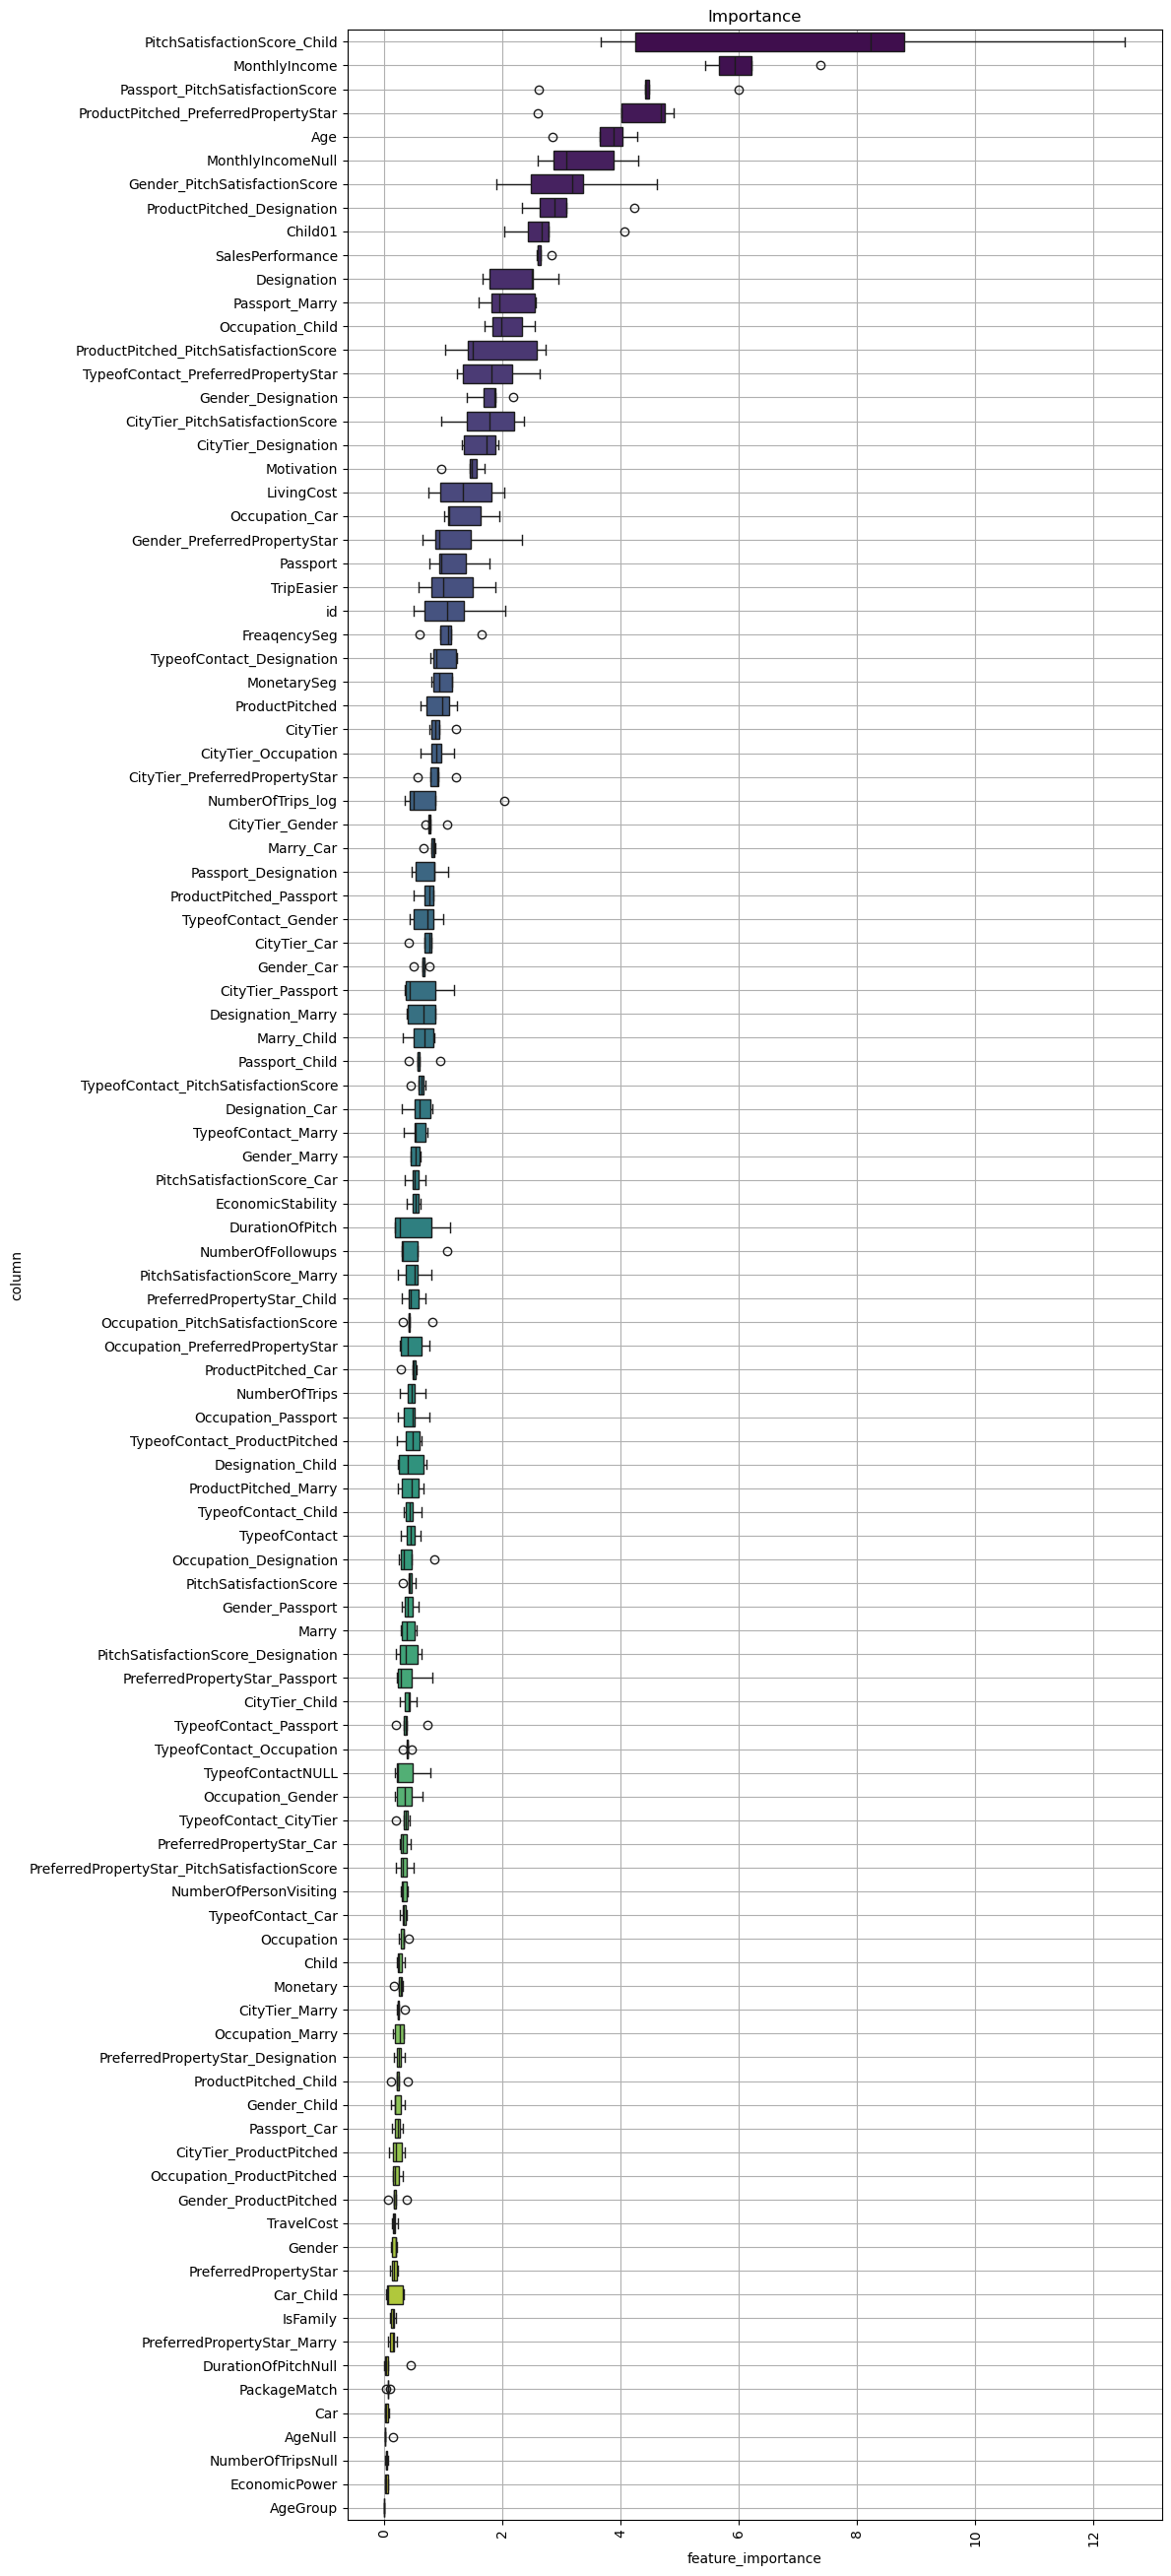

In [39]:
# 特徴量の重要度

def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                        axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    print(feature_importance_df)
    #feature_importance_df_drop_speed = feature_importance_df[feature_importance_df["column"] != "speed"]
    sns.boxplot(data=feature_importance_df,
                x="feature_importance",
                y="column",
                order=order,
                ax=ax,
                palette="viridis",
                orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, X)

# Classifier

In [12]:
# 学習モデル Classifier

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=50)
cv_list = list(skf.split(X, y))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostClassifier(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict_proba(va_x)[:, 1]
        models.append(model)
    return oof_pred, models

params = {
    'scale_pos_weight': 497/2992,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'iterations': 8000,
    'learning_rate': 0.005,
    'depth': 5,
    # 'cat_features': category_columns,
    'l2_leaf_reg': 7,    # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X, y, cv_list, params)

0:	test: 0.7193144	best: 0.7193144 (0)	total: 11.3ms	remaining: 1m 30s
100:	test: 0.7825418	best: 0.7829431 (79)	total: 273ms	remaining: 21.4s
200:	test: 0.7825585	best: 0.7840970 (126)	total: 525ms	remaining: 20.4s
300:	test: 0.7855351	best: 0.7858863 (284)	total: 806ms	remaining: 20.6s
400:	test: 0.7885284	best: 0.7885284 (400)	total: 1.08s	remaining: 20.5s
500:	test: 0.7893144	best: 0.7896488 (470)	total: 1.37s	remaining: 20.5s
600:	test: 0.7899498	best: 0.7902007 (597)	total: 1.65s	remaining: 20.3s
700:	test: 0.7897157	best: 0.7904348 (622)	total: 1.93s	remaining: 20.1s
800:	test: 0.7899498	best: 0.7904348 (622)	total: 2.19s	remaining: 19.7s
900:	test: 0.7899666	best: 0.7904348 (622)	total: 2.48s	remaining: 19.5s
1000:	test: 0.7900836	best: 0.7904348 (622)	total: 2.78s	remaining: 19.5s
1100:	test: 0.7898495	best: 0.7904348 (622)	total: 3.06s	remaining: 19.2s
1200:	test: 0.7898997	best: 0.7904348 (622)	total: 3.32s	remaining: 18.8s
1300:	test: 0.7899331	best: 0.7904348 (622)	total: 

# 提出

In [32]:
# for col in category_columns:
#     df_submit[col] = df_submit[col].astype('str')

y_submit = np.zeros(len(df_test))
for model in models:
    y_submit += model.predict(df_test) / len(models)

index = pd.read_csv('data/test.csv')['id'].values
df_submit = pd.DataFrame({
    "id": index,
    "prediction": y_submit
})

df_submit['prediction'] = np.where(df_submit['prediction'] < 0, 0, df_submit['prediction'])
df_submit.head()

,id,prediction
0,3489,0.065666
1,3490,0.156267
2,3491,0.323386
3,3492,0.382348
4,3493,0.346381


In [33]:
path = 'submission/submit_23_回帰モデルで補完した特徴量選択.csv'

In [34]:
df_submit.to_csv(path, index=False, header=None)

# シード値アンサンブル

In [126]:
def catboost_seed_ensemble(seed):
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cv_list = list(skf.split(X, y))

    def train_catboost(X, y, cv, params: dict = None):
        if params is None:
            params = {}

        models = []
        n_records = len(X)
        oof_pred = np.zeros((n_records, ))
        for i, (tr_idx, va_idx) in enumerate(cv):
            tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
            tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
            model = cb.CatBoostRegressor(**params)
            model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
            oof_pred[va_idx] = model.predict(va_x)
            models.append(model)
        return oof_pred, models

    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'AUC',
        'iterations': 9000,
        'learning_rate': 0.005,
        'depth': 5,
        # 'cat_features': category_columns,
        'l2_leaf_reg': 5,  # 3 ~ 10
        'verbose': 200,
        'random_seed': 42,
    }

    oof, models = train_catboost(X, y, cv_list, params)

    y_submit = np.zeros(len(df_submit))
    for model in models:
        y_submit += model.predict(df_submit) / len(models)
    
    return y_submit

In [127]:
# 1モデル1分46秒
seed = np.arange(50)
y_submit_list = []

for seed in seed:
    y_submit = catboost_seed_ensemble(seed)
    y_submit_list.append(y_submit)

y_submit = np.sum(y_submit_list, axis=0) / len(y_submit_list)
print(y_submit)

0:	test: 0.8001294	best: 0.8001294 (0)	total: 10.3ms	remaining: 1m 32s
100:	test: 0.8267224	best: 0.8282557 (35)	total: 162ms	remaining: 14.3s
200:	test: 0.8281561	best: 0.8282955 (182)	total: 276ms	remaining: 12.1s
300:	test: 0.8272601	best: 0.8282955 (182)	total: 390ms	remaining: 11.3s
400:	test: 0.8278973	best: 0.8283951 (367)	total: 499ms	remaining: 10.7s
500:	test: 0.8276185	best: 0.8288331 (481)	total: 608ms	remaining: 10.3s
600:	test: 0.8281760	best: 0.8288331 (481)	total: 723ms	remaining: 10.1s
700:	test: 0.8281561	best: 0.8288331 (481)	total: 837ms	remaining: 9.91s
800:	test: 0.8284349	best: 0.8288331 (481)	total: 969ms	remaining: 9.92s
900:	test: 0.8275587	best: 0.8288331 (481)	total: 1.08s	remaining: 9.72s
1000:	test: 0.8274194	best: 0.8288331 (481)	total: 1.2s	remaining: 9.59s
1100:	test: 0.8268618	best: 0.8288331 (481)	total: 1.32s	remaining: 9.45s
1200:	test: 0.8264237	best: 0.8288331 (481)	total: 1.44s	remaining: 9.33s
1300:	test: 0.8255078	best: 0.8288331 (481)	total: 1

In [128]:
index = pd.read_csv('data/test.csv')['id'].values
df_submit = pd.DataFrame({
    "id": index,
    "prediction": y_submit
})

df_submit['prediction'] = np.where(df_submit['prediction'] < 0, 0, df_submit['prediction'])
df_submit.head()

,id,prediction
0,3489,0.067197
1,3490,0.216530
2,3491,0.334484
3,3492,0.412721
4,3493,0.338511


In [129]:
path = 'submission/submit_23_シード値アンサンブル.csv'

In [130]:
df_submit.to_csv(path, index=False, header=None)